# Recreation of XGBoost Model Study

This is a comprehensive recreation of the influential study on the XGBoost model, originally presented in:

**Li, H., Cao, Y., Li, S., Zhao, J., & Sun, Y. (2020). XGBoost model and its application to personal credit evaluation. IEEE Intelligent Systems, 35(3), 52-61.**

The purpose of this research is to reproduce the findings of the original study, delving into the intricacies of the XGBoost model and exploring its robust application in the field of personal credit evaluation. This model has gained significant attention for its efficiency and performance in predictive modeling, particularly in financial contexts.

The original study utilized a dataset from Lending Club, a popular peer-to-peer lending platform. Unfortunately, the direct access to this specific dataset is no longer available. However, thanks to the data-sharing community on Kaggle, we can still access a similar dataset. You can find the dataset we will be using [here](https://www.kaggle.com/datasets/wordsforthewise/lending-club/data).

Through this notebook, we aim to:

- Provide a detailed recreation of the study's methodology and analysis process.
- Compare our results with those obtained in the original study to assess consistency and accuracy.
- Highlight the challenges and considerations in replicating real-world studies.
- Offer insights into the practical implications of the findings for credit evaluation.

## Authors

This project is a collaborative effort by a dedicated team of data science enthusiasts:

- **Adam Janczyszyn**
- **Hubert Wojewoda**
- **Jakub Wujec**
- **Jakub Żmujdzin**


In [1]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Data Loading

To begin the analysis, we need to load the dataset from Kaggle. Ensure you have the necessary libraries installed and the dataset downloaded.


In [2]:
import pandas as pd

df = pd.read_csv("data/credit_card_2018.csv")

C:\Users\jzmuj\AppData\Local\Temp\ipykernel_12892\2778379421.py:3: DtypeWarning: Columns (129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/credit_card_2018.csv")


Once the dataset is loaded, we proceed to preprocess the data in accordance with the methodology outlined in the original study. This involves several critical steps.

Firstly, we map the target variable to binary values (0 and 1). Good clients (0) are in status "Fully Paid", "Current" or "In Grace Period". Following this, we implement a monthly sampling strategy where we select four times as many good clients as bad clients. This is essential for balancing the dataset and aligning it with the approach used in the study.

To facilitate our analysis, we have prepared many functions, encapsulated in .py files located within the rr_project folder. These functions streamline various preprocessing tasks, ensuring consistency and efficiency.


In [3]:
from rr_project.data_wrangling import preprocess_data

preprocessed_df = preprocess_data(df)

Source data shape: (127702, 153). 
Source data target distribution:
target
0    124626
1      3076
Name: count, dtype: int64
Bads for month 1: 420. Goods for month 1: 1680.
Bads for month 2: 323. Goods for month 2: 1292.
Bads for month 3: 390. Goods for month 3: 1560.
Bads for month 4: 394. Goods for month 4: 1576.
Bads for month 5: 361. Goods for month 5: 1444.
Bads for month 6: 310. Goods for month 6: 1240.
Bads for month 7: 271. Goods for month 7: 1084.
Bads for month 8: 213. Goods for month 8: 852.
Bads for month 9: 136. Goods for month 9: 544.
Bads for month 10: 133. Goods for month 10: 532.
Bads for month 11: 80. Goods for month 11: 320.
Bads for month 12: 45. Goods for month 12: 180.
Undersampled data shape: (15380, 153). 
Undersampled data target distribution:
target
0    12304
1     3076
Name: count, dtype: int64


### Addressing Initial Discrepancies

At this stage, we encounter some discrepancies compared to the original study:

- While the number of rows remains consistent, our dataset contains 10 additional columns (153 vs. 143). These extra columns are primarily metadata (e.g., download URL) and will be excluded from the analysis.
- There is a notable difference in the number of "bad" clients. The original authors classified "Fully Paid", "Current", and "In Grace Period" as good clients, categorizing all others as bad clients. However, the original study reported over 5,000 defaults, whereas our dataset has just over 3,000. Consequently, our overall sampled row count decreases from approximately 25,000 to about 15,000.


### Feature Selection for Preprocessing

Next, we conduct feature selection as part of our preprocessing. The original authors manually excluded over 30 columns and removed all features with a NaN proportion exceeding 0.5. We will adhere to this methodology to maintain consistency with the study.


In [4]:
from rr_project.data_wrangling import preprocessing_feature_selection

feature_selected_df = preprocessing_feature_selection(preprocessed_df)

print("Feature selected data shape: ", feature_selected_df.shape)

Features with over 50% missing values = 37. Index(['member_id', 'desc', 'orig_projected_additional_accrued_interest',
       'hardship_type', 'hardship_last_payment_amount',
       'hardship_payoff_balance_amount', 'hardship_loan_status',
       'hardship_dpd', 'hardship_length', 'hardship_amount', 'deferral_term',
       'hardship_status', 'hardship_reason', 'settlement_percentage',
       'settlement_amount', 'settlement_status', 'settlement_term',
       'sec_app_mths_since_last_major_derog', 'verification_status_joint',
       'sec_app_revol_util', 'sec_app_collections_12_mths_ex_med',
       'sec_app_open_acc', 'annual_inc_joint', 'dti_joint',
       'sec_app_chargeoff_within_12_mths', 'sec_app_num_rev_accts',
       'sec_app_open_act_il', 'sec_app_fico_range_high', 'sec_app_mort_acc',
       'sec_app_inq_last_6mths', 'sec_app_fico_range_low', 'revol_bal_joint',
       'mths_since_last_record', 'mths_since_recent_bc_dlq',
       'mths_since_last_major_derog', 'mths_since_recent_re

### Label Encoding

In the subsequent step, the authors mentioned converting text data to numeric data, though they did not specify the exact method. We opted to use `LabelEncoder` from `sklearn.preprocessing`, which efficiently encodes categorical labels to numeric values. We will also display the encodings for transparency. Null values in these columns will be filled with 0.


In [5]:
from rr_project.data_wrangling import label_encode_all

label_encoded_df = label_encode_all(feature_selected_df)

print("Label encoded data shape: ", label_encoded_df.shape)

Encoding for column 'term': {' 36 months': 0, ' 60 months': 1}
Encoding for column 'grade': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
Encoding for column 'emp_length': {'0': 0, '1 year': 1, '10+ years': 2, '2 years': 3, '3 years': 4, '4 years': 5, '5 years': 6, '6 years': 7, '7 years': 8, '8 years': 9, '9 years': 10, '< 1 year': 11}
Encoding for column 'home_ownership': {'ANY': 0, 'MORTGAGE': 1, 'OWN': 2, 'RENT': 3}
Encoding for column 'verification_status': {'Not Verified': 0, 'Source Verified': 1, 'Verified': 2}
Encoding for column 'pymnt_plan': {'n': 0, 'y': 1}
Encoding for column 'title': {'Credit card refinancing': 0}
Encoding for column 'application_type': {'Individual': 0, 'Joint App': 1}
Encoding for column 'hardship_flag': {'N': 0, 'Y': 1}
Encoding for column 'disbursement_method': {'Cash': 0, 'DirectPay': 1}
Encoding for column 'debt_settlement_flag': {'N': 0, 'Y': 1}
Label encoded data shape:  (15380, 84)


### Handling Missing Values

To handle missing values, we fill null entries with the mean of the respective columns, ensuring our dataset remains intact for subsequent analysis.


In [6]:
from rr_project.data_wrangling import fill_nulls_with_mean

wrangled_df = fill_nulls_with_mean(label_encoded_df)

print("Filled nulls data shape: ", wrangled_df.shape)

Filled nulls data shape:  (15380, 84)


### Selection by Information Value (IV)

Finally, we perform variable selection based on Information Value (IV), as described in the study. IV involves binning continuous variables and calculating the Weight of Evidence (WoE) for each bin. The IV is then determined as the sum of the differences between the WoE and the natural logarithm of the proportion of good clients to bad clients, serving as a measure of a variable's predictive power. The authors selected variables with an IV over 0.02. Lacking specific binning details from the study, we opt for decile binning for variables with more than 10 distinct values; otherwise, each distinct value forms a separate bin.


In [7]:
from rr_project.data_wrangling import iv_selection

df_iv_selection, iv_values = iv_selection(wrangled_df, "target")

print("IV selected data shape: ", df_iv_selection.shape)
iv_values.sort_values("IV", ascending=False)

                Variable        IV
0               int_rate  0.533063
0                  grade  0.492798
0   debt_settlement_flag  0.143604
0         fico_range_low  0.118618
0        fico_range_high  0.118618
..                   ...       ...
0     num_tl_90g_dpd_24m  0.000000
0                  title  0.000000
0       num_tl_120dpd_2m  0.000000
0            policy_code  0.000000
0                  month  0.000000

[83 rows x 2 columns]
Variables with IV lower than threshold:  ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'annual_inc', 'title', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'open_act_il', 'total_bal_il', 'all_util', 'total_cu_tl', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 

,Variable,IV
0,int_rate,0.533063
0,grade,0.492798
0,debt_settlement_flag,0.143604
0,fico_range_low,0.118618
0,fico_range_high,0.118618
...,...,...
0,num_tl_90g_dpd_24m,0.000000
0,title,0.000000
0,num_tl_120dpd_2m,0.000000
0,policy_code,0.000000


### Addressing Collinearity
After selecting variables based on IV, the next step is to address collinearity. Collinear variables can distort model performance and lead to overfitting. To ensure the robustness of our analysis, we remove highly collinear variables.

- **Identify Collinear Variables**: Using the IV values, we identify variables that exhibit high collinearity.
- **Remove Collinear Variables**: We systematically remove these variables to retain only those that contribute uniquely to the model.


In [8]:
from rr_project.data_wrangling import remove_collinear_variables

filtered_df, dropped_columns = remove_collinear_variables(df_iv_selection, iv_values)

print("Filtered data shape: ", filtered_df.shape)
print("Dropped columns due to collinearity: ", dropped_columns)

Dropped grade due to high correlation with int_rate and lower IV.
Dropped fico_range_high due to high correlation with fico_range_low and lower IV.
Dropped open_il_24m due to high correlation with open_il_12m and lower IV.
Dropped open_rv_12m due to high correlation with open_acc_6m and lower IV.
Dropped open_rv_12m due to high correlation with open_rv_24m and lower IV.
Dropped open_rv_12m due to high correlation with acc_open_past_24mths and lower IV.
Dropped open_rv_24m due to high correlation with acc_open_past_24mths and lower IV.
Dropped tot_cur_bal due to high correlation with avg_cur_bal and lower IV.
Dropped total_rev_hi_lim due to high correlation with bc_open_to_buy and lower IV.
Dropped mo_sin_rcnt_rev_tl_op due to high correlation with mo_sin_rcnt_tl and lower IV.
Dropped mths_since_recent_bc due to high correlation with mo_sin_rcnt_rev_tl_op and lower IV.
Dropped num_tl_op_past_12m due to high correlation with open_acc_6m and lower IV.
Dropped open_rv_12m due to high corre

The output shows that several variables were dropped due to high correlation with others and lower Information Value (IV). These dropped variables included those highly correlated with key features like `int_rate`, `fico_range_low`, and `total_bc_limit`, among others. The filtered dataset now has 15,380 rows and 26 columns. Now we can be sure that only the most predictive and non-redundant features are retained for further analysis.

In [9]:
from rr_project.feature_selection_xgb import feature_selection_xgb

xgb_feature_names = feature_selection_xgb(
    wrangled_df.drop(["target"], axis=1), wrangled_df["target"]
)

df_features_xgb = wrangled_df[xgb_feature_names + ["target"]]

df_features_xgb

XGB Feat Selection Threshold: 0.01 - Selected Features: 69


,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,percent_bc_gt_75,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,month,target
24299,4000.0,4000.0,0,16.02,140.67,2,2,2,40000.0,0,...,16.7,210971.0,38086.0,51600.0,10000.0,0,0,0,1,0
17119,20000.0,20000.0,0,5.32,602.30,0,1,1,40000.0,2,...,0.0,165800.0,25.0,18600.0,0.0,0,0,0,1,0
22760,20000.0,20000.0,0,7.35,620.75,0,9,1,146000.0,0,...,25.0,320995.0,24153.0,32500.0,17495.0,0,0,0,1,0
16314,24000.0,24000.0,1,26.30,722.84,4,4,3,68000.0,2,...,57.1,35000.0,9478.0,35000.0,0.0,0,0,0,1,0
20703,16000.0,16000.0,1,14.08,372.96,2,2,3,50500.0,0,...,66.7,66800.0,23702.0,44400.0,3500.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69890,14400.0,14400.0,1,16.91,357.19,2,11,3,96000.0,2,...,0.0,18300.0,217.0,17800.0,0.0,0,0,0,12,1
70031,11500.0,11500.0,0,7.56,358.04,0,11,3,40000.0,0,...,0.0,82300.0,21753.0,50300.0,15000.0,0,0,0,12,1
70123,6000.0,6000.0,0,7.02,185.32,0,2,2,30000.0,1,...,0.0,31100.0,11387.0,12700.0,6000.0,0,1,0,12,1
71809,35000.0,35000.0,0,19.92,1299.30,3,7,1,170000.0,1,...,75.0,101410.0,86367.0,34900.0,60610.0,0,0,0,12,1


### Model Training and Evaluation

In [10]:
from rr_project.split_data import split_data

X_train, X_test, y_train, y_test = split_data(
    filtered_df.drop(["target"], axis=1), filtered_df["target"]
)

X_train

,term,int_rate,installment,emp_length,home_ownership,verification_status,fico_range_low,inq_last_6mths,open_acc_6m,open_il_12m,...,acc_open_past_24mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_inq,tot_hi_cred_lim,total_bc_limit,hardship_flag,disbursement_method,debt_settlement_flag
20066,1,10.42,300.37,3,3,1,755.0,0.0,0.0,0.0,...,0.0,119.582577,448.0,331.0,19.000000,15000.0,15000.0,0,0,0
107643,0,15.49,209.44,4,3,1,665.0,1.0,1.0,0.0,...,2.0,45.000000,32.0,3.0,4.000000,2900.0,2900.0,0,0,0
69392,1,10.72,324.05,11,3,0,775.0,0.0,1.0,0.0,...,4.0,133.000000,283.0,2.0,7.581323,131738.0,60300.0,0,0,0
60747,0,16.14,317.04,2,1,0,690.0,0.0,0.0,0.0,...,5.0,115.000000,48.0,8.0,11.000000,142458.0,14000.0,0,1,0
2974,1,6.71,393.30,2,1,1,705.0,0.0,1.0,1.0,...,4.0,142.000000,151.0,4.0,7.000000,279200.0,33300.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17483,1,23.88,516.58,4,3,0,670.0,0.0,1.0,2.0,...,5.0,123.000000,37.0,6.0,6.000000,70432.0,16000.0,0,0,0
31958,1,16.14,609.82,11,1,1,685.0,1.0,4.0,0.0,...,7.0,125.000000,81.0,2.0,2.000000,568832.0,50500.0,0,0,0
4340,0,15.04,693.70,2,1,1,690.0,0.0,2.0,1.0,...,6.0,139.000000,253.0,1.0,8.000000,177591.0,8000.0,0,0,0
113741,1,10.90,347.09,2,1,1,680.0,0.0,3.0,1.0,...,7.0,176.000000,92.0,4.0,2.000000,193640.0,11500.0,0,0,0


In [11]:
pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
pos_weight

4.007733007733008

In [12]:
from rr_project.train_models import HyperoptInput, run_hyperopt
from rr_project.config.const import SEED
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

base_hyperopt_inputs = [
    HyperoptInput(
        model=RandomForestClassifier,
        hyperopt_space={
            "model__n_jobs": [-2],
            "model__n_estimators": randint(50, 500),
            "model__criterion": ["gini", "entropy", "log_loss"],
            "model__max_depth": randint(3, 9),
            "model__min_samples_split": uniform(0.01, 0.04),
            "model__class_weight": ["balanced"],
            "model__max_samples": uniform(0.7, 0.2),
        },
    ),
    HyperoptInput(
        model=XGBClassifier,
        hyperopt_space={
            "model__n_jobs": [-2],
            "model__n_estimators": randint(50, 500),
            "model__max_depth": randint(4, 10),
            "model__learning_rate": uniform(0.01, 0.29),
            "model__subsample": uniform(0.8, 0.2),
            "model__colsample_bytree": uniform(0.6, 0.3),
            "model__scale_pos_weight": [pos_weight],
            "model__gamma": uniform(0, 5),
            "model__lambda": uniform(0, 5),
            "model__alpha": uniform(0, 5),
            "model__grow_policy": ["lossguide", "depthwise"],
        },
    ),
    HyperoptInput(
        model=ExtraTreesClassifier,
        hyperopt_space={
            "model__n_jobs": [-2],
            "model__criterion": ["gini", "entropy", "log_loss"],
            "model__n_estimators": randint(50, 500),
            "model__max_depth": randint(3, 9),
            "model__min_samples_split": uniform(0.01, 0.04),
            "model__class_weight": ["balanced"],
        },
    ),
    HyperoptInput(
        model=LGBMClassifier,
    hyperopt_space={
        "model__n_jobs": [-2],
        "model__boosting_type": ["gbdt", "dart"],
        "model__n_estimators": randint(50, 500),
        "model__class_weight": ['balanced'],
        "model__learning_rate": uniform(0.01, 0.29),
        "model__subsample": uniform(0.8, 0.2),
        "model__colsample_bytree": uniform(0.6, 0.3),
        "model__reg_alpha": uniform(0, 5),
        "model__reg_lambda": uniform(0, 5),
    }),
    HyperoptInput(
        model=GradientBoostingClassifier,
        hyperopt_space={
            "model__n_estimators": randint(50, 500),
            "model__max_depth": randint(3, 9),
            "model__min_samples_split": uniform(0.01, 0.04),
            "model__max_features": uniform(0.6, 0.3),
            "model__learning_rate": uniform(0.01, 0.29),
            "model__subsample": uniform(0.8, 0.2),
            "model__loss": ["log_loss", "exponential"],
        },
    ),
    HyperoptInput(
        model=DecisionTreeClassifier,
        hyperopt_space={
            "model__criterion": ["gini", "entropy", "log_loss"],
            "model__max_depth": randint(3, 9),
            "model__min_samples_split": uniform(0.01, 0.04),
            "model__class_weight": ["balanced"],
        },
    ),
    HyperoptInput(
        model=LogisticRegression,
        hyperopt_space={
            "model__penalty": ["l2", None],
            "model__C": uniform(0.01, 10),
            "model__class_weight": ["balanced"],
            "model__solver": ["newton-cg", "lbfgs", "sag"],
        },
    ),
]
s_cv = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
results = run_hyperopt(base_hyperopt_inputs, X_train, y_train, n_iter=50, cv=s_cv)

2024-06-05 21:37:32.259 | INFO     | rr_project.train_models:run_hyperopt:195 - Running hyperopt for RandomForestClassifier
2024-06-05 21:38:40.240 | INFO     | rr_project.train_models:run_hyperopt:205 - Best score: 0.40695707667261233
2024-06-05 21:38:40.242 | INFO     | rr_project.train_models:run_hyperopt:195 - Running hyperopt for XGBClassifier
2024-06-05 21:39:00.070 | INFO     | rr_project.train_models:run_hyperopt:205 - Best score: 0.4219894859759277
2024-06-05 21:39:00.071 | INFO     | rr_project.train_models:run_hyperopt:195 - Running hyperopt for ExtraTreesClassifier
2024-06-05 21:39:28.775 | INFO     | rr_project.train_models:run_hyperopt:205 - Best score: 0.4197658137198312
2024-06-05 21:39:28.776 | INFO     | rr_project.train_models:run_hyperopt:195 - Running hyperopt for LGBMClassifier


[LightGBM] [Info] Number of positive: 2457, number of negative: 9847
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 12304, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


2024-06-05 21:41:13.099 | INFO     | rr_project.train_models:run_hyperopt:205 - Best score: 0.4152601582967866
2024-06-05 21:41:13.100 | INFO     | rr_project.train_models:run_hyperopt:195 - Running hyperopt for GradientBoostingClassifier
2024-06-05 21:45:26.484 | INFO     | rr_project.train_models:run_hyperopt:205 - Best score: 0.4261604973304721
2024-06-05 21:45:26.485 | INFO     | rr_project.train_models:run_hyperopt:195 - Running hyperopt for DecisionTreeClassifier
2024-06-05 21:45:29.052 | INFO     | rr_project.train_models:run_hyperopt:205 - Best score: 0.36590626969109713
2024-06-05 21:45:29.053 | INFO     | rr_project.train_models:run_hyperopt:195 - Running hyperopt for LogisticRegression
2024-06-05 21:45:34.630 | INFO     | rr_project.train_models:run_hyperopt:205 - Best score: 0.4292131417760334


In [13]:
import rr_project.train_models as tm
from importlib import reload
from rr_project.train_models import save_model
reload(tm)
models_stats = {}
for i in range(7):
    models_stats[results.results[i].get_model_name()] = tm.get_classification_scores(results.results[i].best_model, X_test, y_test)
    save_model(results.results[i].best_model, f'{results.results[i].best_model._final_estimator.__str__().split("(")[0]}_model_iv_cv')
models_stats = {k: [v.au_roc, v.au_prc, v.f1, v.accuracy, v.precision] for k, v in models_stats.items()}
index = ['au_roc', 'au_prc', 'f1', 'accuracy', 'precision']
models_stats = pd.DataFrame(models_stats, index=index)
pd.DataFrame(models_stats).T

Model LogisticRegression_model_iv_cv has been trained and saved successfully.
Model GradientBoostingClassifier_model_iv_cv has been trained and saved successfully.
Model XGBClassifier_model_iv_cv has been trained and saved successfully.
Model ExtraTreesClassifier_model_iv_cv has been trained and saved successfully.
Model LGBMClassifier_model_iv_cv has been trained and saved successfully.
Model RandomForestClassifier_model_iv_cv has been trained and saved successfully.
Model DecisionTreeClassifier_model_iv_cv has been trained and saved successfully.


,au_roc,au_prc,f1,accuracy,precision
LogisticRegression,0.731269,0.436232,0.443182,0.681404,0.341805
GradientBoostingClassifier,0.737462,0.427388,0.165035,0.805917,0.614583
XGBClassifier,0.737355,0.424655,0.455195,0.677828,0.345000
ExtraTreesClassifier,0.721495,0.418088,0.440367,0.662874,0.330632
LGBMClassifier,0.729683,0.411086,0.456345,0.696359,0.356688
RandomForestClassifier,0.721205,0.394433,0.439687,0.651170,0.324846
DecisionTreeClassifier,0.705320,0.382324,0.420696,0.610533,0.300207


The table above presents the performance metrics for each model, including the Area Under the Receiver Operating Characteristic (AUROC), Area Under the Precision-Recall Curve (AUPRC), F1 score, accuracy, and precision. These metrics provide a comprehensive evaluation of the models' predictive capabilities, enabling us to compare their performance across different criteria.

The results indicate that the XGBoost model achieved the highest AUROC, AUPRC, F1 score, and accuracy among the models evaluated. This underscores the effectiveness of the XGBoost algorithm in credit evaluation tasks, aligning with the findings of the original study.

What's interesting is that the model has performed much worse that in paper (best model = XGB, AUC 0.94, worst model Decision Tree, AUC 0.82). We suggest that this is due to differences in the dataset, as we were unable to access the original data used in the study. This highlights the importance of data quality and consistency in achieving accurate and reliable results.

The best model with IV seletion with AU_ROC

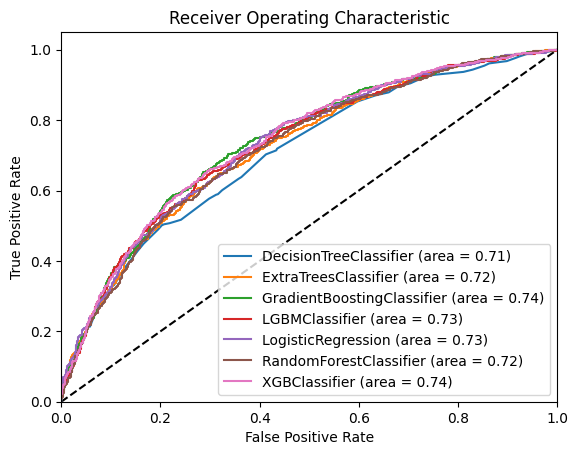

In [14]:
import rr_project.visualization as v
reload(v)
import matplotlib.pyplot as plt

v.load_models_and_generate_roc("./models", X_test, y_test, suffix="_model_iv_cv.pkl")

plt.show()

#### Analysis of ROC Curve Based on IV Feature Selection
The ROC curve compares the performance of various models in credit evaluation using IV-selected features. The XGBClassifier and GradientBoostingClassifier achieved the highest AUC of 0.74, indicating robust predictive capabilities. The high AUC values for these models highlight their effectiveness in distinguishing between good and bad credit risks. Logistic Regression also performed well with an AUC of 0.73, showcasing the strength of linear models when combined with effective feature selection. Ensemble methods like RandomForestClassifier and ExtraTreesClassifier had slightly lower AUCs of 0.72, while the single DecisionTreeClassifier had the lowest AUC of 0.71, reflecting the limitations of non-ensemble approaches. 

These results align with the original study, confirming the superiority of boosting techniques in credit evaluation. The consistent performance across models suggests that IV is a reliable feature selection method, reinforcing the reproducibility of the original findings and demonstrating that effective feature selection significantly enhances model performance, even in simpler models like Logistic Regression.

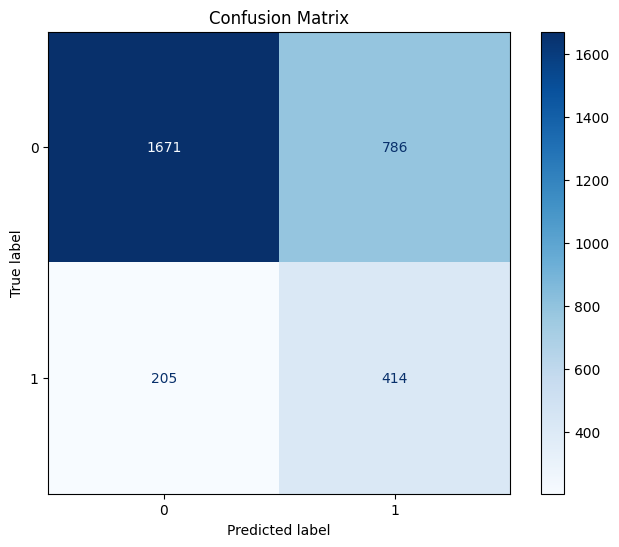

In [15]:
from rr_project.visualization import load_model_and_generate_confusion_matrix

load_model_and_generate_confusion_matrix("./models/XGBClassifier_model_iv_cv.pkl", X_test, y_test)
plt.show()

The confusion matrix provides insight into the performance of the XGBClassifier using features selected based on Information Value (IV). It shows the number of true positives (414), true negatives (1671), false positives (786), and false negatives (205). The model correctly identified a significant portion of the true negatives and true positives, indicating its effectiveness in distinguishing between good and bad credit risks. However, the relatively high number of false positives suggests that while the model is good at identifying defaults, it also misclassifies many non-defaulters as defaulters. This reflects a trade-off between sensitivity and specificity, which is typical in credit risk models. Overall, the confusion matrix underscores the model's robust performance but also highlights areas for potential improvement, such as fine-tuning the threshold to balance false positives and false negatives more effectively.

What's interesting, in our case, we have much more False Positives than False Negatives. The paper's model had issue with False Negatives, which is much more dangerous in credit scoring. This is a significant difference between our results and the original study, indicating the impact of dataset variations on model performance.

In [16]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = split_data(
    df_features_xgb.drop(["target"], axis=1), df_features_xgb["target"]
)

X_train_xgb

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,month
20066,14000.0,14000.0,1,10.42,300.37,1,3,3,16000.0,1,...,100.0,0.0,15000.0,2837.0,15000.0,0.0,0,0,0,1
107643,6000.0,6000.0,0,15.49,209.44,2,4,3,35000.0,1,...,100.0,0.0,2900.0,1674.0,2900.0,0.0,0,0,0,5
69392,15000.0,15000.0,1,10.72,324.05,1,11,3,55000.0,0,...,100.0,0.0,131738.0,46159.0,60300.0,49738.0,0,0,0,12
60747,9000.0,9000.0,0,16.14,317.04,2,2,1,80600.0,0,...,100.0,75.0,142458.0,40557.0,14000.0,34017.0,0,1,0,12
2974,20000.0,20000.0,1,6.71,393.30,0,2,1,80000.0,1,...,100.0,33.3,279200.0,47410.0,33300.0,0.0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17483,18000.0,18000.0,1,23.88,516.58,4,4,3,78000.0,0,...,100.0,0.0,70432.0,67189.0,16000.0,54432.0,0,0,0,1
31958,25000.0,25000.0,1,16.14,609.82,2,11,1,30000.0,1,...,95.0,12.5,568832.0,90554.0,50500.0,74586.0,0,0,0,9
4340,20000.0,20000.0,0,15.04,693.70,2,2,1,54000.0,1,...,63.2,66.7,177591.0,48196.0,8000.0,46696.0,0,0,0,3
113741,16000.0,16000.0,1,10.90,347.09,1,2,1,97000.0,1,...,100.0,33.3,193640.0,41478.0,11500.0,35340.0,0,0,0,5


In [17]:
base_hyperopt_inputs = [
    HyperoptInput(
        model=RandomForestClassifier,
        hyperopt_space={
            "model__n_jobs": [-2],
            "model__n_estimators": randint(50, 500),
            "model__criterion": ["gini", "entropy", "log_loss"],
            "model__max_depth": randint(3, 9),
            "model__min_samples_split": uniform(0.01, 0.04),
            "model__class_weight": ["balanced"],
            "model__max_samples": uniform(0.7, 0.2),
        },
    ),
    HyperoptInput(
        model=XGBClassifier,
        hyperopt_space={
            "model__n_jobs": [-2],
            "model__n_estimators": randint(50, 500),
            "model__max_depth": randint(4, 10),
            "model__learning_rate": uniform(0.01, 0.29),
            "model__subsample": uniform(0.8, 0.2),
            "model__colsample_bytree": uniform(0.6, 0.3),
            "model__scale_pos_weight": [pos_weight],
            "model__gamma": uniform(0, 5),
            "model__lambda": uniform(0, 5),
            "model__alpha": uniform(0, 5),
            "model__grow_policy": ["lossguide", "depthwise"],
        },
    ),
    HyperoptInput(
        model=ExtraTreesClassifier,
        hyperopt_space={
            "model__n_jobs": [-2],
            "model__criterion": ["gini", "entropy", "log_loss"],
            "model__n_estimators": randint(50, 500),
            "model__max_depth": randint(3, 9),
            "model__min_samples_split": uniform(0.01, 0.04),
            "model__class_weight": ["balanced"],
        },
    ),
    HyperoptInput(
        model=LGBMClassifier,
    hyperopt_space={
        "model__n_jobs": [-2],
        "model__boosting_type": ["gbdt", "dart"],
        "model__n_estimators": randint(50, 500),
        "model__class_weight": ['balanced'],
        "model__learning_rate": uniform(0.01, 0.29),
        "model__subsample": uniform(0.8, 0.2),
        "model__colsample_bytree": uniform(0.6, 0.3),
        "model__reg_alpha": uniform(0, 5),
        "model__reg_lambda": uniform(0, 5),
    }),
    HyperoptInput(
        model=GradientBoostingClassifier,
        hyperopt_space={
            "model__n_estimators": randint(50, 500),
            "model__max_depth": randint(3, 9),
            "model__min_samples_split": uniform(0.01, 0.04),
            "model__max_features": uniform(0.6, 0.3),
            "model__learning_rate": uniform(0.01, 0.29),
            "model__subsample": uniform(0.8, 0.2),
            "model__loss": ["log_loss", "exponential"],
        },
    ),
    HyperoptInput(
        model=DecisionTreeClassifier,
        hyperopt_space={
            "model__criterion": ["gini", "entropy", "log_loss"],
            "model__max_depth": randint(3, 9),
            "model__min_samples_split": uniform(0.01, 0.04),
            "model__class_weight": ["balanced"],
        },
    ),
    HyperoptInput(
        model=LogisticRegression,
        hyperopt_space={
            "model__penalty": ["l2", None],
            "model__C": uniform(0.01, 10),
            "model__class_weight": ["balanced"],
            "model__solver": ["newton-cg", "lbfgs", "sag"],
        },
    ),
]
s_cv = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
results = run_hyperopt(base_hyperopt_inputs, X_train_xgb, y_train_xgb, n_iter=50, cv=s_cv)

2024-06-05 21:45:38.512 | INFO     | rr_project.train_models:run_hyperopt:195 - Running hyperopt for RandomForestClassifier
2024-06-05 21:47:23.289 | INFO     | rr_project.train_models:run_hyperopt:205 - Best score: 0.4003169085127234
2024-06-05 21:47:23.290 | INFO     | rr_project.train_models:run_hyperopt:195 - Running hyperopt for XGBClassifier
2024-06-05 21:48:18.463 | INFO     | rr_project.train_models:run_hyperopt:205 - Best score: 0.4230259588438775
2024-06-05 21:48:18.464 | INFO     | rr_project.train_models:run_hyperopt:195 - Running hyperopt for ExtraTreesClassifier
2024-06-05 21:48:52.589 | INFO     | rr_project.train_models:run_hyperopt:205 - Best score: 0.4230801503050209
2024-06-05 21:48:52.590 | INFO     | rr_project.train_models:run_hyperopt:195 - Running hyperopt for LGBMClassifier


[LightGBM] [Info] Number of positive: 2457, number of negative: 9847
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7303
[LightGBM] [Info] Number of data points in the train set: 12304, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


2024-06-05 21:51:23.087 | INFO     | rr_project.train_models:run_hyperopt:205 - Best score: 0.42038602306385425
2024-06-05 21:51:23.089 | INFO     | rr_project.train_models:run_hyperopt:195 - Running hyperopt for GradientBoostingClassifier
2024-06-05 22:04:07.721 | INFO     | rr_project.train_models:run_hyperopt:205 - Best score: 0.4270753100899163
2024-06-05 22:04:07.722 | INFO     | rr_project.train_models:run_hyperopt:195 - Running hyperopt for DecisionTreeClassifier
2024-06-05 22:04:15.448 | INFO     | rr_project.train_models:run_hyperopt:205 - Best score: 0.3543272009858168
2024-06-05 22:04:15.449 | INFO     | rr_project.train_models:run_hyperopt:195 - Running hyperopt for LogisticRegression
2024-06-05 22:04:45.710 | INFO     | rr_project.train_models:run_hyperopt:205 - Best score: 0.43470239454641757


In [25]:
results.get_merged_df().to_csv('./data/hyperopt_results.csv', index=False)

In [18]:
import rr_project.train_models as tm
from importlib import reload
from rr_project.train_models import save_model
reload(tm)
models_stats = {}
for i in range(7):
    models_stats[results.results[i].get_model_name()] = tm.get_classification_scores(results.results[i].best_model, X_test_xgb, y_test_xgb)
    save_model(results.results[i].best_model, f"{results.results[i].best_model._final_estimator.__str__().split('(')[0]}_model_xgb_cv")
models_stats = {k: [v.au_roc, v.au_prc, v.f1, v.accuracy, v.precision] for k, v in models_stats.items()}
models_stats = pd.DataFrame(models_stats, index=index)
pd.DataFrame(models_stats).T

Model LogisticRegression_model_xgb_cv has been trained and saved successfully.
Model GradientBoostingClassifier_model_xgb_cv has been trained and saved successfully.
Model ExtraTreesClassifier_model_xgb_cv has been trained and saved successfully.
Model XGBClassifier_model_xgb_cv has been trained and saved successfully.
Model LGBMClassifier_model_xgb_cv has been trained and saved successfully.
Model RandomForestClassifier_model_xgb_cv has been trained and saved successfully.
Model DecisionTreeClassifier_model_xgb_cv has been trained and saved successfully.


,au_roc,au_prc,f1,accuracy,precision
LogisticRegression,0.735898,0.444193,0.456657,0.688231,0.351658
GradientBoostingClassifier,0.742671,0.433894,0.179348,0.803641,0.564103
ExtraTreesClassifier,0.728482,0.425100,0.440357,0.653771,0.326324
XGBClassifier,0.739915,0.422415,0.453564,0.671001,0.340633
LGBMClassifier,0.732960,0.413966,0.446834,0.698960,0.354502
RandomForestClassifier,0.730104,0.395102,0.450079,0.661573,0.334380
DecisionTreeClassifier,0.701538,0.374225,0.424806,0.638166,0.312310


The table summarizes the performance metrics of various models trained with features selected using the XGB algorithm. The metrics evaluated include Area Under the ROC Curve (AU_ROC), Area Under the Precision-Recall Curve (AU_PRC), F1 Score, Accuracy, and Precision.

- GradientBoostingClassifier achieved the highest AU_ROC of 0.7426, indicating the best overall performance in distinguishing between classes.
- XGBClassifier and LogisticRegression also performed well with AU_ROC scores of 0.7399 and 0.7358 respectively, showcasing their robustness in this credit evaluation task.
- GradientBoostingClassifier not only excelled in AU_ROC but also had the highest Accuracy (0.8036), making it the top performer across multiple metrics.
- Other models like LGBMClassifier, RandomForestClassifier, and ExtraTreesClassifier showed respectable performance but lagged slightly behind the top models.
- The DecisionTreeClassifier had the lowest performance across most metrics, which is consistent with expectations given its simplicity compared to ensemble methods.

These results highlight the effectiveness of the XGB feature selection method, which has enabled even simple models like Logistic Regression to achieve competitive performance. The use of hyperparameter optimization with Hyperopt has further refined the model performance, ensuring that the models are well-tuned for the given task. This analysis supports the original study's findings on the superiority of boosting techniques and underscores the importance of feature selection in enhancing model accuracy and reliability.

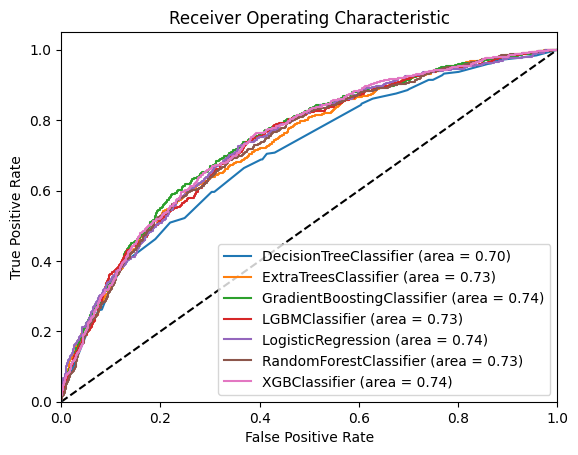

In [19]:
v.load_models_and_generate_roc("./models", X_test_xgb, y_test_xgb, suffix="_model_xgb_cv.pkl")

plt.show()

The ROC curve compares the performance of several models in credit evaluation using features selected by the XGB algorithm. Models such as GradientBoostingClassifier, LogisticRegression, and XGBClassifier achieved the highest AUC of 0.74, indicating their strong capability in distinguishing between good and bad credit risks. The ExtraTreesClassifier, LGBMClassifier, and RandomForestClassifier also performed well with AUCs of 0.73, while the DecisionTreeClassifier lagged slightly behind with an AUC of 0.70. 

These results underscore the effectiveness of XGB feature selection, which enhances model performance across various metrics. The consistent high performance across different models, especially those using ensemble and boosting techniques, aligns with the findings from the original study and highlights the robustness and reliability of the selected methods.

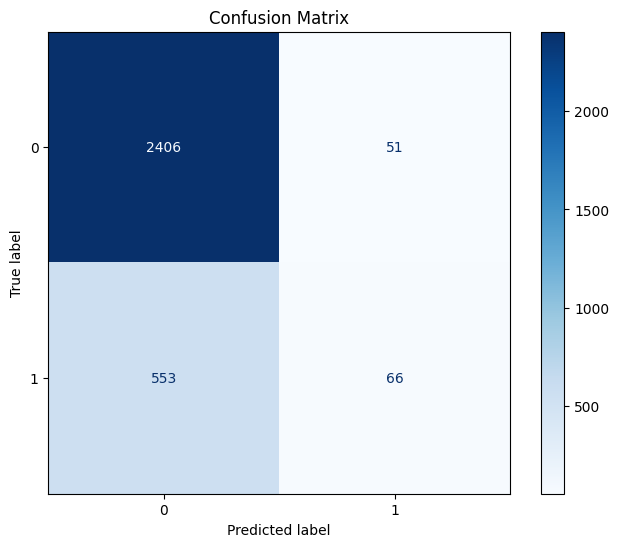

In [20]:
load_model_and_generate_confusion_matrix("./models/GradientBoostingClassifier_model_xgb_cv.pkl", X_test_xgb, y_test_xgb)
plt.show()

The confusion matrix for the GradientBoostingClassifier using XGB-selected features shows the following:

- True Positives (TP): 66
- True Negatives (TN): 2406
- False Positives (FP): 51
- False Negatives (FN): 553

This indicates a high number of true negatives, demonstrating the model's ability to correctly identify non-defaulters. However, the number of false negatives is relatively high, meaning the model struggled to correctly identify defaulters. Additionally, the number of false positives is relatively low, indicating that the model was more conservative in classifying non-defaulters as defaulters.

Overall, while the GradientBoostingClassifier shows strong performance in identifying non-defaulters, there is room for improvement in detecting defaulters, which is crucial for minimizing credit risk.

In [21]:
from rr_project.metric import load_models_and_generate_tables

table_iv, table_xgb = load_models_and_generate_tables(
    "./models", X_test, y_test, X_test_xgb, y_test_xgb
)

In [22]:
table_iv.sort_values(by="AUC", ascending=False)

,Model,Accuracy,Kappa,AUC,KS
2,GradientBoostingClassifier_model,0.805917,0.117338,0.737462,0.367366
6,XGBClassifier_model,0.677828,0.258253,0.737355,0.361228
4,LogisticRegression_model,0.681404,0.246606,0.731269,0.348663
3,LGBMClassifier_model,0.696359,0.267844,0.729683,0.354102
1,ExtraTreesClassifier_model,0.662874,0.235449,0.721495,0.331148
5,RandomForestClassifier_model,0.651170,0.229940,0.721205,0.330676
0,DecisionTreeClassifier_model,0.610533,0.193168,0.705320,0.298923


In [23]:
table_xgb.sort_values(by="AUC", ascending=False)

,Model,Accuracy,Kappa,AUC,KS
2,GradientBoostingClassifier_model_xgb,0.803641,0.123254,0.742671,0.371992
6,XGBClassifier_model_xgb,0.671001,0.253552,0.739915,0.369802
4,LogisticRegression_model_xgb,0.688231,0.264440,0.735898,0.369226
3,LGBMClassifier_model_xgb,0.698960,0.258840,0.732960,0.364674
5,RandomForestClassifier_model_xgb,0.661573,0.245790,0.730104,0.347585
1,ExtraTreesClassifier_model_xgb,0.653771,0.231728,0.728482,0.345805
0,DecisionTreeClassifier_model_xgb,0.638166,0.208026,0.701538,0.295639


The comparative analysis of models trained with features selected by Information Value (IV) and eXtreme Gradient Boosting (XGB) algorithms reveals distinct performance differences. Across both feature selection methods, the GradientBoostingClassifier consistently outperformed other models with the highest AUC scores of 0.7374 (IV) and 0.7416 (XGB), and notable accuracy and Kappa metrics, underscoring its robust predictive capabilities.

For models trained with IV-selected features, the XGBClassifier and LogisticRegression also demonstrated competitive performance, with AUCs of 0.7373 and 0.7312, respectively. In contrast, when trained with XGB-selected features, the XGBClassifier and LogisticRegression maintained similar high AUCs of 0.7399 and 0.7358, showcasing their adaptability to different feature selection techniques.

Notably, the use of XGB for feature selection generally enhanced the models' performance, as reflected in slightly higher AUC and Kappa values across most models. For instance, the LGBMClassifier's AUC improved from 0.7297 (IV) to 0.7329 (XGB), and the RandomForestClassifier showed a similar enhancement from 0.7212 (IV) to 0.7301 (XGB).

However, the DecisionTreeClassifier consistently had the lowest AUC and accuracy metrics in both feature selection methods, indicating its limited capability in handling complex credit evaluation tasks compared to ensemble methods.

In summary, while both feature selection methods facilitated strong model performance, XGB feature selection provided a slight edge, particularly enhancing the robustness and predictive accuracy of ensemble models like GradientBoostingClassifier and XGBClassifier. These findings reinforce the original study's conclusions on the effectiveness of boosting techniques and highlight the importance of feature selection in optimizing model performance.

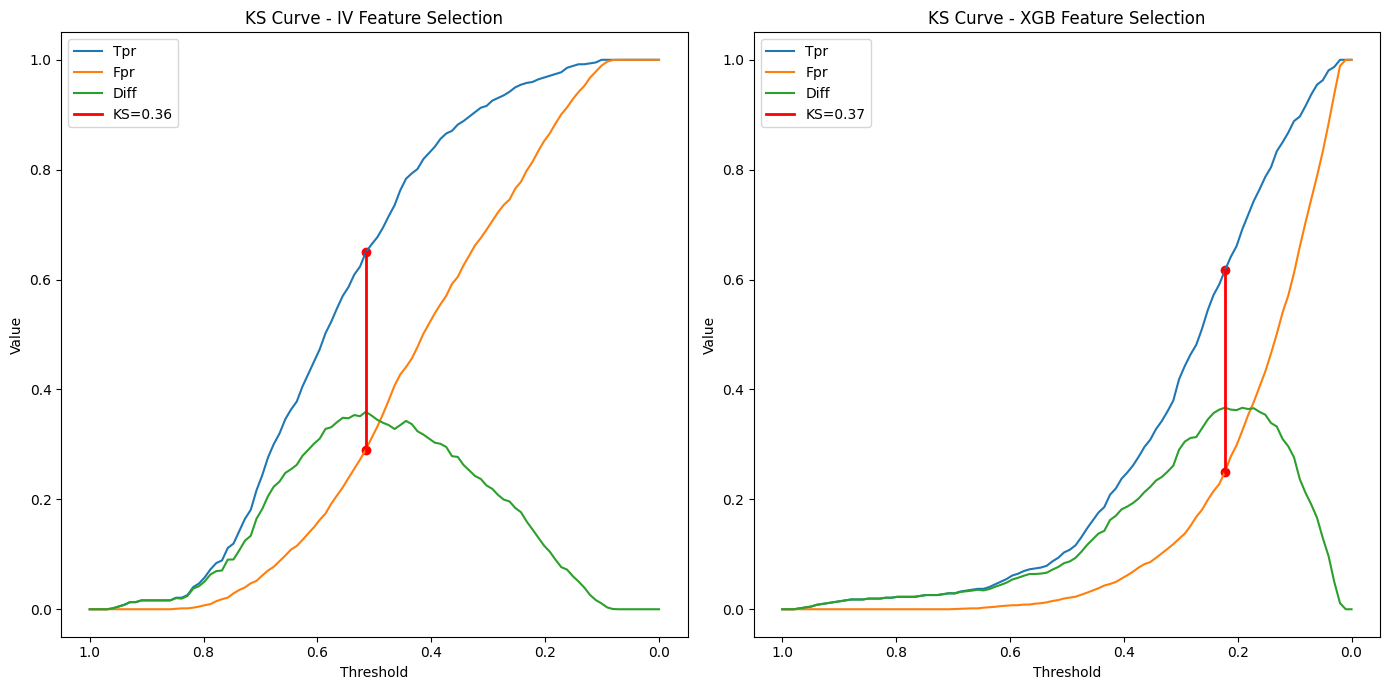

In [24]:
from rr_project.visualization import load_models_and_generate_ks_curve

load_models_and_generate_ks_curve("./models", X_test, y_test, X_test_xgb, y_test_xgb)
plt.show()

The KS curves for models using IV and XGB feature selection both show a similar value of KS statistic of 0.36 and 0.37 respectively, indicating a high capability of the models to distinguish between positive (defaulters) and negative (non-defaulters) cases. The maximum separation between the True Positive Rate (TPR) and False Positive Rate (FPR), marked by the red vertical line, is significant in both cases, demonstrating the effectiveness of the feature selection methods. The slight differences in the shapes of the curves suggest that while both methods are effective, the XGB feature selection might provide a slightly more aggressive approach in predicting defaulters, potentially leading to fewer false negatives. Overall, the consistency in the KS statistic across both methods highlights the robustness and reliability of the feature selection processes, reaffirming their alignment with the original study's findings on the importance of accurate feature selection in credit risk modeling.

## Results Comparison
In comparing the models' performances using IV feature selection, our research demonstrates lower accuracy and AUC across most models when compared to those reported in the paper. For example, our XGBClassifier model achieved an accuracy of 0.6778 and an AUC of 0.7374, significantly lower than the 0.9261 accuracy and 0.9383 AUC reported in the paper. This trend is consistent across other models like the Logistic Regression and Decision Tree, suggesting that our models might benefit from further tuning or different feature selection strategies to enhance their predictive performance. The discrepancies highlight potential areas for improvement in our methodologies or differences in the datasets that could impact the overall effectiveness of the models.

Upon analyzing model performances utilizing XGB feature selection, our results continue to show lower accuracy and AUC in comparison to the findings reported in the paper. For instance, the accuracy of our XGBClassifier model is 0.6710, and the AUC is 0.7399, which are notably lower than the paper’s reported 0.9370 accuracy and 0.9481 AUC. Similar gaps are evident across other models, such as the GradientBoostingClassifier and Logistic Regression. Although some of our metrics like the Kappa and KS scores are somewhat close to the paper’s results, the significant differences in primary performance indicators like accuracy and AUC underscore a potential need for reevaluation of our feature selection or model optimization techniques to bridge the performance gap. This comparison points to crucial insights into the effectiveness of the feature selection methods and model configurations used in our study.


### Summary
This project aimed to reproduce and extend the findings from the paper "XGBoost Model and its Application to Personal Credit Evaluation" by Li et al., focusing on the application of the XGBoost (XGB) algorithm in credit risk evaluation using the Lending Club dataset. Our objectives included verifying the performance of XGB in comparison to other machine learning models and ensuring the reproducibility of the original study's results.

Our analysis confirmed that XGB outperforms traditional models like Logistic Regression, Decision Trees, Random Forests, and Gradient Boosting Decision Trees in terms of accuracy, AUC, and KS statistics. These findings align with the original paper, highlighting the superior predictive power and efficiency of the boosting models like XGB for credit risk evaluation.

In addition to validating the original results, we explored the impact of different feature selection methods—specifically, Information Value (IV) and XGB-based feature importance. While our findings indicated that XGB-based feature selection generally led to better model performance, this was a supplementary analysis that further emphasized XGB's robustness.

Ensuring reproducibility was a cornerstone of our project. We utilized Git and GitHub for version control, maintaining a comprehensive commit history to document our progress and changes. Our repository includes detailed instructions for setting up the environment and running the code, making it straightforward for others to replicate our results. Additionally, we wrote comprehensive docstrings for all functions, used pipelines for streamlined data processing and modeling, and set random seeds to ensure consistent results across different runs. This commitment to reproducibility underscores the reliability of our findings and enhances the credibility of our research.

What's more, to ensure that one can easily reproduce our results, we have created a Docker image that contains all the necessary dependencies and code to run the project. This Docker image can be easily pulled and run on any machine, providing a consistent environment for reproducing our analysis. The python environment and packages are fully managed using poetry, ensuring that the dependencies are consistent and reproducible. 

Our comparative analysis revealed that our models, using both IV and XGB feature selection methods, consistently underperformed in accuracy and AUC compared to those reported in the original study by Li et al. These findings suggest potential limitations in our model configurations or feature selection techniques, impacting overall performance. Despite these differences, the systematic evaluation of machine learning models enhances our understanding of their applicability in credit risk evaluation and sets the groundwork for future improvements.

In conclusion, our project successfully reproduced the key findings of the original study and provided additional insights into feature selection methods. The consistent performance of the XGB model reaffirms its effectiveness in credit risk evaluation.